# Scanning 2 targets consecutively
Scan information is captured to PCAP for inspection.    
In the simple case you will start a scan, end the scan and wait for the PCAP to finish writing to analyse the data    
For the dual scan case you do not want to wait for the PCAP to finish writing, you want to start the second scan as soon as the first scan ends.    
Thus the development challenge here is to see that you can use the transmit CNIC in duplex mode to allow the receive CNIC to finish writing the first PCAP at the same time that you capture the data for the second PCAP

Developer note: And you want to be able to rerun this repeatedly without failure to ensure it is robust before including it in the automated pipeline

## Imports

In [1]:
# %pip install --user --extra-index-url https://artefact.skao.int/repository/pypi-internal/simple git+https://gitlab.com/ska-telescope/ska-low-csp-test  # for visibility unpacking and plotting
# %pip install --extra-index-url https://artefact.skao.int/repository/pypi-internal/simple git+https://gitlab.com/ska-telescope/ska-low-csp-test  # for visibility unpacking and plotting
# %pip install --extra-index-url https://artefact.skao.int/repository/pypi-internal/simple pytango ska-control-model backoff

In [27]:
import datetime
import itertools
import json
import os
import time
import typing
from io import BytesIO
from typing import Any, Generator, Iterable

import backoff
import tango
from PIL import Image
from matplotlib import pyplot as plt
from ska_control_model import AdminMode, ObsState
import random

from ska_low_csp_test.cbf.visibilities import Polarization, unpack_pcap_file
from ska_low_csp_test.domain import plotting
from ska_low_csp_test.domain.spead import LowCbfVisibilitySpeadItem, LowCbfSdpSpeadStationBaselineMapping

## Configure Settings

Collect all variables that need to be set in a single location

In [3]:
CNIC_FW_VERSION = "0.1.12"
CNIC_FW_SOURCE = "nexus"  # "nexus" or "gitlab"

CNIC_FORCE_DOWNLOAD = False  # Force CNICs to re-download firmware.

VIS = "vis:0.0.7"

In [4]:
SCAN_1_ID = 1234
SCAN_2_ID = 1235
SUBARRAY_ID = 1
SUBSTATION_ID = 1
BEAM_ID = 1
FSP_ID = 1

SDP_IP = "192.168.0.1"  # arbitrary IP

In [5]:
prefix = datetime.datetime.now().strftime("%Y%m%d_%H%M%S_")
file_1_prefix = prefix + "scan1_"
file_2_prefix = prefix + "scan2_"

### Tango devices

In [6]:
TANGO_DB_PORT = 10000
TANGO_DB_SVC = "ska-low-csp-databaseds"
TANGO_DB_NAMESPACE = "ska-low-csp-baseline"
TANGO_DB_HOST = f"tango://{TANGO_DB_SVC}.{TANGO_DB_NAMESPACE}.svc.cluster.local:{TANGO_DB_PORT}"

In [7]:
allocator = tango.DeviceProxy(f"{TANGO_DB_HOST}/low-cbf/allocator/0")
cbf_controller = tango.DeviceProxy(f"{TANGO_DB_HOST}/low-cbf/control/0")
cbf_subarray = tango.DeviceProxy(f"{TANGO_DB_HOST}/low-cbf/subarray/{SUBARRAY_ID:02}")
cnic_rx = tango.DeviceProxy(f"{TANGO_DB_HOST}/low-cbf/cnic/1")
cnic_vd = cnic_rx
connector = tango.DeviceProxy(f"{TANGO_DB_HOST}/low-cbf/connector/0")
csp_controller = tango.DeviceProxy(f"{TANGO_DB_HOST}/low-csp/control/0")
csp_subarray = tango.DeviceProxy(f"{TANGO_DB_HOST}/low-csp/subarray/{SUBARRAY_ID:02}")
delaypoly = tango.DeviceProxy(f"{TANGO_DB_HOST}/low-cbf/delaypoly/0")

### Test data

In [8]:
# CNIC-VD configuration
station_ids = [345, 350, 352, 431]
n_stations = len(station_ids)  # pylint: disable=invalid-name
STATIONS = [[station, SUBSTATION_ID] for station in station_ids]

n_channels = 96  # pylint: disable=invalid-name
CHANNELS = list(range(208, 208 + n_channels))

cw_channels = [209, 256, 303]
cw_fine_channels = {209: 0, 256: 0, 303: 0}


def cnic_config(scan_id: int):
    counter = itertools.count()
    cnic_vd_cfg = [  # config is a list of dicts - one per SPEAD stream
        {
            "scan": scan_id,
            "subarray": SUBARRAY_ID,
            "station": station,
            "substation": substation,
            "frequency": channel,
            "beam": BEAM_ID,
            "sources": {
                "x": [
                    {
                        "tone": channel in cw_channels,
                        "scale": 4 if channel in cw_channels else 0,
                        "fine_frequency": cw_fine_channels[channel] if channel in cw_fine_channels else 0,
                    },
                    {"tone": False, "seed": station, "scale": 1000},
                    # {"tone": False, "seed": 0, "scale": 0},
                ],
                "y": [
                    {"tone": False, "seed": station, "scale": 1000},
                    # {"tone": False, "seed": 0, "scale": 0},
                ],
            },
        }
        for station, substation in STATIONS
        for channel in CHANNELS
    ]
    return cnic_vd_cfg

### Receiver configuration

In [9]:
PCAP_FILENAME = file_1_prefix + f"corr-{VIS.split(':', 2)[1].replace('.', '_')}.cnic-{cnic_rx.fw_version.replace('.', '_')}.sdp.pcap"
PCAP_FILE_1_RX = os.path.join("/", "test-data", "pcap", "output", PCAP_FILENAME)

N_VISIBILITIES = 5
OUTPUT_PACKET_COUNT = 144 * len(CHANNELS) * (N_VISIBILITIES + 1)
OUTPUT_PACKET_SIZE = 200

RX_1_PARAMS = {
    "method": "receive_pcap",
    "arguments": {
        "out_filename": PCAP_FILE_1_RX,
        "packet_size": OUTPUT_PACKET_SIZE,
        "n_packets": OUTPUT_PACKET_COUNT,
    },
}

In [10]:
PCAP_FILENAME = file_2_prefix + f"corr-{VIS.split(':', 2)[1].replace('.', '_')}.cnic-{cnic_vd.fw_version.replace('.', '_')}.sdp.pcap"
PCAP_FILE_2_RX = os.path.join("/", "test-data", "pcap", "output", PCAP_FILENAME)

RX_2_PARAMS = {
    "method": "receive_pcap",
    "arguments": {
        "out_filename": PCAP_FILE_2_RX,
        "packet_size": OUTPUT_PACKET_SIZE,
        "n_packets": OUTPUT_PACKET_COUNT,
    },
}

## CNIC Initialization

Load the transmit and receive CNIC personalities

In [11]:
for cnic in [cnic_vd, cnic_rx]:
    # yes yes naughty blocking SelectPersonality command
    cnic.set_timeout_millis(300_000)

    if not CNIC_FORCE_DOWNLOAD and cnic.activePersonality == "cnic":
        print(f"Already running CNIC firmware on {cnic.name()}, skipping download!")
        cnic.StopSourceDelays()
    else:
        print(f'Selecting personality for {cnic.name()}')
        cnic.SelectPersonality(
            json.dumps({"version": CNIC_FW_VERSION, "source": CNIC_FW_SOURCE, "memory": "4095Ms:4095Ms:4095Mi:4095Mi"})
        )
    cnic.hbm_pktcontroller__duplex = True
    cnic.CallMethod(json.dumps({"method": "stop_receive"}))
    cnic.CallMethod(json.dumps({"method": "reset"})) 

Already running CNIC firmware on low-cbf/cnic/2, skipping download!
Already running CNIC firmware on low-cbf/cnic/1, skipping download!


### Set CNIC to Duplex mode

In [12]:
cnic_vd.hbm_pktcontroller__duplex = True

### Configure VD

In [13]:
print(cnic_vd.name())
cnic_vd.ConfigureVirtualDigitiser(json.dumps(cnic_config(SCAN_1_ID)))

low-cbf/cnic/2


### Clear P4 Port counters

In [14]:
connector.ResetPortStatistics()

[array([0], dtype=int32), ['Ports Statistics Reset']]

### Convenience logic

In [15]:
def format_port_status(connector_: tango.DeviceProxy) -> str:
    """Pretty-print P4 Port information to string.

    :param connector: CbfConnectorProxy Tango DeviceProxy wrapper
    :returns: formatted string, listing for each port:
        the port identifier,
        the port enable status,
        the port status,
        the configured port speed,
        the ingress packet count of the switch port,
        the egress packet count of the switch port
    """
    ports_ = get_port_status(connector_)

    return "\n".join(
        [
            "  ".join(
                [
                    "Port: {port[port]:>4}",
                    "Enable: {port[enable]!s:<5}",
                    "Up: {port[up]!s:<5}",
                    "Speed: {port[speed]:<5}",
                    "Rx: {port[packets_received]:8}",
                    "Tx: {port[packets_sent]:8}",
                ]
            ).format(port=each)
            for each in ports_.values()
        ]
    )


def get_port_status(connector_: tango.DeviceProxy) -> list[dict[str:str]]:
    """Retrieve P4 Packet Counters.

    :returns: dictionary of the configured attributes and packet counts of each P4 switch port
    """
    port_status_json = connector_.PortStatus
    port_status_obj = json.loads(port_status_json)
    return {
        each["$PORT_NAME"]: {
            "port": each["$PORT_NAME"],
            "enable": each["$PORT_ENABLE"],
            "up": each["$PORT_UP"],
            "speed": each["$SPEED"],
            "packets_received": each["packets_received"],
            "packets_sent": each["packets_sent"],
        }
        for each in port_status_obj["Ports_Status"]
    }


def get_ports_counts(
    connector_: tango.DeviceProxy,
    ports_: list[str],
) -> dict[str, (int, int)]:
    """
    Return the number of packets received and send through each P4 switch ports connected.

    :param connector: CbfConnectorProxy Tango DeviceProxy wrapper
    :param ports: a list of port identifiers to query
    :returns: a list a received and sent packet count tuple for each port
    """
    port_counts, port_status = {}, get_port_status(connector_)
    for port_ in ports_:
        try:
            status = port_status[port_]
            port_count = status["packets_received"], status["packets_sent"]
        except KeyError:
            # Unknown port
            port_count = (0, 0)
        port_counts[port_] = port_count
    return port_counts


def wait_for_attribute_value(
    device_: tango.DeviceProxy,
    attribute: str,
    value: typing.Any = True,
    failure_message: str = "Timed out waiting for attribute value",
    timeout_sec: int = 120,
) -> None:
    """
    Wait until an attribute has a certain value

    :param device: Tango device proxy with the attribute to check
    :param attribute: The name of the attribute
    :param value: Expected value (defaults to True)
    :param failure_message: Message for the exception on failure.
    Defaults to "Timed out waiting for attribute value".
    A note about duration is appended.
    :param timeout_sec: Approximate time-out period  in seconds (in reality
    it could be longer due to delays waiting for each attribute read)
    :raises RuntimeError: if expected value not seen before timing out
    """
    deadline = time.time() + timeout_sec
    poll_interval_seconds = 2
    while time.time() < deadline:
        try:
            if device_.read_attribute(attribute).value == value:
                break
        except tango.DevFailed as err_:
            raise AttributeError from err_

        time.sleep(poll_interval_seconds)
    else:
        raise RuntimeError(f"{failure_message} after {timeout_sec} sec")


def wait_for_device_response(
    device_: tango.DeviceProxy,
    failure_message: str = "Timed out waiting for device to respond",
    timeout_sec: int = 120,
) -> None:
    """
    Wait until a device responds.

    :param device: Tango device proxy to wait for
    :param failure_message: Message for the exception on failure.
    Defaults to "Timed out waiting for device to respond".
    A note about duration is appended.
    :param timeout_sec: Approximate time-out period in seconds
    :raises RuntimeError: if the device does not respond in time
    """
    deadline = time.time() + timeout_sec
    poll_interval_seconds = 2
    while time.time() < deadline:
        try:
            device_.ping()
            return
        except tango.ConnectionFailed:
            time.sleep(poll_interval_seconds)
    raise RuntimeError(f"{failure_message} after {timeout_sec} sec")

## Configure routing

### Initialize SUT

In [16]:
csp_controller.adminMode = AdminMode.OFFLINE
wait_for_attribute_value(csp_controller, "iscommunicating", False)
csp_controller.adminMode = AdminMode.ONLINE
wait_for_attribute_value(csp_controller, "iscommunicating", True)

wait_for_attribute_value(csp_subarray, "state", tango.DevState.ON)

In [17]:
print(f"{csp_controller.dev_name()} in {csp_controller.state()}: {str(csp_controller.state())}")
print(
    f"{csp_controller.dev_name()} in {csp_controller.healthState}:",
    f"{str(csp_controller.healthState)}",
)
print(f"{csp_controller.dev_name()} in {csp_controller.adminmode}: {str(csp_controller.adminmode)}")
print(f"{csp_subarray.dev_name()} in {csp_subarray.state()}: {str(csp_subarray.state())}")
print(f"{csp_subarray.dev_name()} in {csp_subarray.healthState}: {str(csp_subarray.healthState)}")
print(f"{csp_subarray.dev_name()} in {csp_subarray.adminmode}: {str(csp_subarray.adminmode)}")
print(f"{csp_subarray.dev_name()} in {csp_subarray.obsState}: {str(csp_subarray.obsState)}")

low-csp/control/0 in ON: ON
low-csp/control/0 in 3: healthState.UNKNOWN
low-csp/control/0 in 0: adminMode.ONLINE
low-csp/subarray/01 in ON: ON
low-csp/subarray/01 in 3: healthState.UNKNOWN
low-csp/subarray/01 in 0: adminMode.ONLINE
low-csp/subarray/01 in 0: obsState.EMPTY


## Assign resources 

In [18]:
print("Assign resources")
assert csp_subarray.obsState == ObsState.EMPTY

ASSIGN_RESOURCES = {
    "interface": "https://schema.skao.int/ska-low-csp-assignresources/3.0",
    "common": {
        "subarray_id": SUBARRAY_ID,
    },
    "lowcbf": {},
}
csp_subarray.AssignResources(json.dumps(ASSIGN_RESOURCES))

print("Waiting for subarray to become IDLE")
wait_for_attribute_value(csp_subarray, "obsState", ObsState.IDLE, "Assignment not finished")
print(f"{csp_subarray.dev_name()} in {str(csp_subarray.obsState)}")

Assign resources
Waiting for subarray to become IDLE
low-csp/subarray/01 in obsState.IDLE


## Time for first scan

### Start capture on first CNIC

In [19]:
print(f"Configuring {cnic_rx.name()} for Rx\n")
cnic_rx.CallMethod(json.dumps(RX_1_PARAMS))

Configuring low-cbf/cnic/1 for Rx



'None'

### Configure scan

In [20]:
print("Configure scan")
assert csp_subarray.obsState == ObsState.IDLE

Configure scan


In [21]:
CONFIGURE = {
    "interface": "https://schema.skao.int/ska-low-csp-configure/3.1",
    "subarray": {
        "subarray_name": "ITC.L.AA0.5.CORR.1",
    },
    "common": {
        "config_id": "Single_scan_data_path",
        "subarray_id": SUBARRAY_ID,
        "frequency_band": "low",
    },
    "lowcbf": {
        "stations": {
            "stns": STATIONS,
            "stn_beams": [
                {
                    "beam_id": BEAM_ID,
                    "freq_ids": CHANNELS,
                    "delay_poly": f"{delaypoly.name()}/delay_s{SUBARRAY_ID:02}_b{BEAM_ID:02}",
                },
            ],
        },
        "vis": {
            "fsp": {
                "firmware": VIS,
                "fsp_ids": [FSP_ID],
            },
            "stn_beams": [
                {
                    "stn_beam_id": SUBSTATION_ID,
                    "host": [[0, SDP_IP]],
                    "mac": [(0, "0c-42-a1-9c-a2-1b")],
                    "port": [(0, 20000, 1)],
                    "integration_ms": 849,
                },
            ],
        },
    },
}

print(json.dumps(CONFIGURE))

print(csp_subarray.ObsState)

csp_subarray.Configure(json.dumps(CONFIGURE))
print("Waiting for subarray to become READY")
wait_for_attribute_value(csp_subarray, "obsState", ObsState.READY, "Subarray not ready")
print("Subarray is READY")

{"interface": "https://schema.skao.int/ska-low-csp-configure/3.1", "subarray": {"subarray_name": "ITC.L.AA0.5.CORR.1"}, "common": {"config_id": "Single_scan_data_path", "subarray_id": 1, "frequency_band": "low"}, "lowcbf": {"stations": {"stns": [[345, 1], [350, 1], [352, 1], [431, 1]], "stn_beams": [{"beam_id": 1, "freq_ids": [208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303], "delay_poly": "low-cbf/delaypoly/0/delay_s01_b01"}]}, "vis": {"fsp": {"firmware": "vis:0.0.5", "fsp_ids": [1]}, "stn_beams": [{"stn_beam_id": 1, "host": [[0, "192.168.0.1"]], "mac": [[0, "0c

### Find CBF processor matching FSP
Identify associated processor device in order to identify the P4 port for routing

In [22]:
correlator_serial = json.loads(allocator.fsps)[f"fsp_{FSP_ID:02}"][0]
print("Correlator FPGA has serial number", correlator_serial)

correlator_fqdn = json.loads(allocator.procDevFqdn)[correlator_serial]
print("Correlator FPGA TANGO device:", correlator_fqdn)

correlator = tango.DeviceProxy(f"{TANGO_DB_HOST}/{correlator_fqdn}")

Correlator FPGA has serial number XFL1XXQM0FKW
Correlator FPGA TANGO device: low-cbf/processor/0.0.0


In [23]:
@backoff.on_exception(backoff.expo, AssertionError, factor=0.05, max_time=60)
def assert_correlator_ready():
    """Check that the correlator is in a ready state."""
    assert "stats_mode" in correlator.get_attribute_list()
    stats: dict = json.loads(correlator.stats_mode)
    assert stats.get("ready", False) is True

print("Waiting for correlator personality to program")
assert_correlator_ready()

print("Resetting correlator")
correlator.DebugRegWrite(json.dumps({"name": "corr_ct1.full_reset", "offset": 0, "value": 1}))
correlator.DebugRegWrite(json.dumps({"name": "corr_ct1.full_reset", "offset": 0, "value": 0}))

Waiting for correlator personality to program
Resetting correlator


### P4 routing and Data Capture

Here we are configuring the P4 routing and the Data Capture. 

In [24]:
def parse_hardware_connections(
    allocator: tango.DeviceProxy,  # pylint: disable = redefined-outer-name
) -> dict[str, str]:
    """Convert `allocator.hardware_connections` prop to `{ "serial": "port" }`.

    :param allocator: Allocator Tango device
    :returns: dictionary with FPGA device serial numbers as the keys, and the
    network switch port numbers as values
    """
    name = "hardware_connections"  # pylint: disable = redefined-outer-name
    prop = allocator.get_property(name)

    alveo_props = [each.split() for each in filter(lambda x: "alveo" in x, prop[name])]
    alveo_ports = [list(filter(lambda x: "alveo" in x or "port" in x, each)) for each in alveo_props]

    ports_ = list(itertools.chain.from_iterable(filter(lambda x: "port" in x, each) for each in alveo_ports))
    port_it = [each.strip("port=") for each in ports_]

    alveos = list(itertools.chain.from_iterable(filter(lambda x: "alveo" in x, each) for each in alveo_ports))
    alveo_it = [each.strip("alveo=") for each in alveos]

    return dict(zip(alveo_it, port_it))

In [25]:
serialno_port = parse_hardware_connections(allocator)
print(serialno_port)

correlator_port = serialno_port[correlator_serial]

print("Correlator FPGA is connected to P4 port", correlator_port)

print("Routing table:", connector.BasicRoutingTable)
print("Routing table:", connector.SdpIpRoutingTable)
print("Routing table:", connector.SpeadUnicastRoutingTable)

{'XFL1IYUNES2E': '5/0', 'XFL1EG4H5YXY': '9/0', 'XFL1XXQM0FKW': '13/0', 'XFL1BB1SEWXK': '17/0', 'XFL1SZ2IUU2I': '21/0', 'XFL121Y1KXMA': '25/0'}
Correlator FPGA is connected to P4 port 13/0
Routing table: {"Basic": [{"ingress port": "0/0", "port": "0/0"}]}
Routing table: {"SDP_IP": [{"IP_Address": "0.0.0.0", "port": "0/0"}]}
Routing table: {"Spead": [{"Frequency": "208", "Beam": "1", "Sub_array": "1", "port": "13/0"}, {"Frequency": "209", "Beam": "1", "Sub_array": "1", "port": "13/0"}, {"Frequency": "210", "Beam": "1", "Sub_array": "1", "port": "13/0"}, {"Frequency": "211", "Beam": "1", "Sub_array": "1", "port": "13/0"}, {"Frequency": "212", "Beam": "1", "Sub_array": "1", "port": "13/0"}, {"Frequency": "213", "Beam": "1", "Sub_array": "1", "port": "13/0"}, {"Frequency": "214", "Beam": "1", "Sub_array": "1", "port": "13/0"}, {"Frequency": "215", "Beam": "1", "Sub_array": "1", "port": "13/0"}, {"Frequency": "216", "Beam": "1", "Sub_array": "1", "port": "13/0"}, {"Frequency": "217", "Beam":

#### Add route from correlator to output CNIC

In [26]:
cnic_rx_port = serialno_port[cnic_rx.serialnumber]
cnic_vd_port = serialno_port[cnic_vd.serialnumber]

print("CNIC RX is connected to P4 port", cnic_rx_port)

command_basic_routes = {
    "basic": [{"src": {"port": correlator_port}, "dst": {"port": cnic_rx_port}}]
}
connector.UpdateBasicEntry(json.dumps(command_basic_routes))

print("Routing table:", connector.BasicRoutingTable)
print("Routing table:", connector.SdpIpRoutingTable)
print("Routing table:", connector.SpeadUnicastRoutingTable)

CNIC RX is connected to P4 port 9/0
Routing table: {"Basic": [{"ingress port": "13/0", "port": "9/0"}]}
Routing table: {"SDP_IP": [{"IP_Address": "0.0.0.0", "port": "0/0"}]}
Routing table: {"Spead": [{"Frequency": "208", "Beam": "1", "Sub_array": "1", "port": "13/0"}, {"Frequency": "209", "Beam": "1", "Sub_array": "1", "port": "13/0"}, {"Frequency": "210", "Beam": "1", "Sub_array": "1", "port": "13/0"}, {"Frequency": "211", "Beam": "1", "Sub_array": "1", "port": "13/0"}, {"Frequency": "212", "Beam": "1", "Sub_array": "1", "port": "13/0"}, {"Frequency": "213", "Beam": "1", "Sub_array": "1", "port": "13/0"}, {"Frequency": "214", "Beam": "1", "Sub_array": "1", "port": "13/0"}, {"Frequency": "215", "Beam": "1", "Sub_array": "1", "port": "13/0"}, {"Frequency": "216", "Beam": "1", "Sub_array": "1", "port": "13/0"}, {"Frequency": "217", "Beam": "1", "Sub_array": "1", "port": "13/0"}, {"Frequency": "218", "Beam": "1", "Sub_array": "1", "port": "13/0"}, {"Frequency": "219", "Beam": "1", "Sub_ar

In [27]:
for name, cnic, port in ("Tx", cnic_vd, cnic_vd_port), ("XF", correlator, correlator_port), ("Rx", cnic_rx, cnic_rx_port):
    print(f"{name}: port: {port:>4}, S/N: {cnic.serialnumber}, {cnic.name()}")
print()
print(f"P4 port status:\n{format_port_status(connector)}")
print()
print("Routing table:", connector.BasicRoutingTable)
print("Routing table:", connector.SdpIpRoutingTable)
print("Routing table:", connector.SpeadUnicastRoutingTable)

Tx: port: 25/0, S/N: XFL121Y1KXMA, low-cbf/cnic/2
XF: port: 13/0, S/N: XFL1XXQM0FKW, low-cbf/processor/0.0.0
Rx: port:  9/0, S/N: XFL1EG4H5YXY, low-cbf/cnic/1

P4 port status:
Port:  1/0  Enable: True   Up: True   Speed: 10G    Rx:      409  Tx:        0
Port:  5/0  Enable: True   Up: True   Speed: 100G   Rx:        0  Tx:      397
Port:  9/0  Enable: True   Up: True   Speed: 100G   Rx:        5  Tx:      397
Port: 13/0  Enable: True   Up: True   Speed: 100G   Rx:        0  Tx:      397
Port: 17/0  Enable: True   Up: True   Speed: 100G   Rx:        0  Tx:      397
Port: 21/0  Enable: True   Up: True   Speed: 100G   Rx:        5  Tx:      397
Port: 25/0  Enable: True   Up: True   Speed: 100G   Rx:        5  Tx:      397
Port: 33/2  Enable: True   Up: False  Speed: 10G    Rx:        0  Tx:        0
Port: 33/3  Enable: True   Up: False  Speed: 10G    Rx:        0  Tx:        0

Routing table: {"Basic": [{"ingress port": "13/0", "port": "9/0"}]}
Routing table: {"SDP_IP": [{"IP_Address": "0

### Start transmitting data

In [28]:
ports = [cnic_vd_port, correlator_port, cnic_rx_port]
cnic_vd.enable_vd = True

In [29]:
print("Packet counts before Scan()")
print(
    "Note that the exact packet count cannot be checked; "
    "this is due to PTP packets, which also contribute to the packet counts."
)
print("This means that the expected packet count is the acceptable lower boundary for the number of packets received.")
print(list(get_ports_counts(connector, ports).values()))

print("Start scan")
assert csp_subarray.obsState == ObsState.READY

SCAN = {
    "interface": "https://schema.skao.int/ska-low-csp-scan/2.0",
    "common": {
        "subarray_id": SUBARRAY_ID,
    },
    "lowcbf": {
        "scan_id": SCAN_1_ID,
    },
}
print(SCAN)

csp_subarray.Scan(json.dumps(SCAN))
print("Waiting for subarray to become SCANNING")
wait_for_attribute_value(csp_subarray, "obsState", ObsState.SCANNING, "Not Scanning")

print("After scan command the packet counts are:")
print(list(get_ports_counts(connector, ports).values()))

Packet counts before Scan()
Note that the exact packet count cannot be checked; this is due to PTP packets, which also contribute to the packet counts.
This means that the expected packet count is the acceptable lower boundary for the number of packets received.
[(5, 397), (0, 397), (5, 397)]
Start scan
{'interface': 'https://schema.skao.int/ska-low-csp-scan/2.0', 'common': {'subarray_id': 1}, 'lowcbf': {'scan_id': 1234}}
Waiting for subarray to become SCANNING
After scan command the packet counts are:
[(340613, 454), (23061, 341062), (6, 23511)]


### Capture PCAP file

In [30]:
print(f"Target Number of packets to capture: {OUTPUT_PACKET_COUNT}")

while not cnic_rx.hbm_pktcontroller__rx_complete:
# while cnic_rx.hbm_pktcontroller__rx_packet_count < OUTPUT_PACKET_COUNT:
    time_ = cnic_rx.timeslave__time
    packets_received = cnic_rx.hbm_pktcontroller__rx_packet_count
    print(f"{time_}: {packets_received}")
    time.sleep(1)

print("\nFinished receiving packets for first scan.")

Target Number of packets to capture: 82944
2024-04-19 15:15:08.771988: 27648
2024-04-19 15:15:09.778784: 41472
2024-04-19 15:15:10.785480: 55296
2024-04-19 15:15:11.793040: 71892

Finished receiving packets for first scan.


### End first scan

In [31]:
print("Ending scan")
csp_subarray.EndScan()
print("Waiting for subarray to become READY")
wait_for_attribute_value(csp_subarray, "obsState", ObsState.READY)

Ending scan
Waiting for subarray to become READY


## Time for second scan

### Change the correlator output route from the Rx CNIC to the Tx CNIC by updating the basic routing table

In [32]:
connector.RemoveBasicEntry(json.dumps({"basic": [{"src": {"port": correlator_port}}]}))

command_basic_routes = {
    "basic": [{"src": {"port": correlator_port}, "dst": {"port": cnic_vd_port}}]
}
connector.UpdateBasicEntry(json.dumps(command_basic_routes))

print("Routing table:", connector.BasicRoutingTable)
print("Routing table:", connector.SdpIpRoutingTable)
print("Routing table:", connector.SpeadUnicastRoutingTable)

Routing table: {"Basic": [{"ingress port": "13/0", "port": "25/0"}]}
Routing table: {"SDP_IP": [{"IP_Address": "0.0.0.0", "port": "0/0"}]}
Routing table: {"Spead": [{"Frequency": "208", "Beam": "1", "Sub_array": "1", "port": "13/0"}, {"Frequency": "209", "Beam": "1", "Sub_array": "1", "port": "13/0"}, {"Frequency": "210", "Beam": "1", "Sub_array": "1", "port": "13/0"}, {"Frequency": "211", "Beam": "1", "Sub_array": "1", "port": "13/0"}, {"Frequency": "212", "Beam": "1", "Sub_array": "1", "port": "13/0"}, {"Frequency": "213", "Beam": "1", "Sub_array": "1", "port": "13/0"}, {"Frequency": "214", "Beam": "1", "Sub_array": "1", "port": "13/0"}, {"Frequency": "215", "Beam": "1", "Sub_array": "1", "port": "13/0"}, {"Frequency": "216", "Beam": "1", "Sub_array": "1", "port": "13/0"}, {"Frequency": "217", "Beam": "1", "Sub_array": "1", "port": "13/0"}, {"Frequency": "218", "Beam": "1", "Sub_array": "1", "port": "13/0"}, {"Frequency": "219", "Beam": "1", "Sub_array": "1", "port": "13/0"}, {"Frequ

### Start capture on second CNIC

In [33]:
print(f"Configuring {cnic_vd.name()} for Rx\n")
cnic_vd.CallMethod(json.dumps(RX_2_PARAMS))

Configuring low-cbf/cnic/2 for Rx



'None'

### Perform the second scan as usual, but monitor the Tx CNIC for packet counts instead of the Rx CNIC (which would be the normal methodology)

In [34]:
print("Packet counts before Scan()")
print(
    "Note that the exact packet count cannot be checked; "
    "this is due to PTP packets, which also contribute to the packet counts."
)
print("This means that the expected packet count is the acceptable lower boundary for the number of packets received.")
print(list(get_ports_counts(connector, ports).values()))

print("Start scan")
assert csp_subarray.obsState == ObsState.READY

SCAN = {
    "interface": "https://schema.skao.int/ska-low-csp-scan/2.0",
    "common": {
        "subarray_id": SUBARRAY_ID,
    },
    "lowcbf": {
        "scan_id": SCAN_2_ID,
    },
}
print(SCAN)

csp_subarray.Scan(json.dumps(SCAN))
print("Waiting for subarray to become SCANNING")
wait_for_attribute_value(csp_subarray, "obsState", ObsState.SCANNING, "Not Scanning")

print("After scan command the packet counts are:")
print(list(get_ports_counts(connector, ports).values()))

Packet counts before Scan()
Note that the exact packet count cannot be checked; this is due to PTP packets, which also contribute to the packet counts.
This means that the expected packet count is the acceptable lower boundary for the number of packets received.
[(1378953, 595), (124416, 1379539), (7, 125011)]
Start scan
{'interface': 'https://schema.skao.int/ska-low-csp-scan/2.0', 'common': {'subarray_id': 1}, 'lowcbf': {'scan_id': 1235}}
Waiting for subarray to become SCANNING
After scan command the packet counts are:
[(1795593, 15663), (139415, 1796236), (7, 125068)]


In [35]:
print(f"Target Number of packets to capture: {OUTPUT_PACKET_COUNT}")

while not cnic_rx.hbm_pktcontroller__rx_complete:
    time_ = cnic_vd.timeslave__time
    packets_received = cnic_vd.hbm_pktcontroller__rx_packet_count
    print(f"{time_}: {packets_received}")
    print(f"{time_}: {correlator.stats_delay}")
    time.sleep(1)

print("\nFinished receiving packets for second scan.")

Target Number of packets to capture: 82944

Finished receiving packets for second scan.


In [36]:
while not cnic_vd.finished_receive:
    time_ = cnic_vd.timeslave__time
    packets_received = cnic_vd.hbm_pktcontroller__rx_packet_count
    print(f"{time_}: {packets_received}")
    time.sleep(1)

print("\nFinished writing 1st PCAP.")
print(PCAP_FILE_1_RX)

2024-04-19 15:15:17.183894: 27648
2024-04-19 15:15:18.190828: 41472
2024-04-19 15:15:19.197954: 55296
2024-04-19 15:15:20.204141: 69120
2024-04-19 15:15:21.211259: 91697
2024-04-19 15:15:22.218123: 110592
2024-04-19 15:15:23.225067: 124416
2024-04-19 15:15:24.232098: 138240
2024-04-19 15:15:25.239678: 152064
2024-04-19 15:15:26.249871: 170306
2024-04-19 15:15:27.265155: 193536
2024-04-19 15:15:28.275169: 207360
2024-04-19 15:15:29.293413: 221184
2024-04-19 15:15:30.312895: 235008
2024-04-19 15:15:31.332129: 252136
2024-04-19 15:15:32.354058: 276480
2024-04-19 15:15:33.371284: 290304
2024-04-19 15:15:34.416909: 304128
2024-04-19 15:15:35.432305: 317952
2024-04-19 15:15:36.452985: 337228
2024-04-19 15:15:37.480162: 359424
2024-04-19 15:15:38.513740: 373248
2024-04-19 15:15:39.534462: 387072
2024-04-19 15:15:40.558072: 400896
2024-04-19 15:15:41.573216: 422195
2024-04-19 15:15:42.599652: 442368
2024-04-19 15:15:43.636562: 456192
2024-04-19 15:15:44.658077: 470016
2024-04-19 15:15:45.68740

In [37]:
while not cnic_rx.finished_receive:
    time_ = cnic_rx.timeslave__time
    packets_received = cnic_rx.hbm_pktcontroller__rx_packet_count
    print(f"{time_}: {packets_received}")
    print(f"{time_}: {correlator.stats_delay}")
    time.sleep(1)

print("\nFinished writing 2nd PCAP.")
print(PCAP_FILE_2_RX)


Finished writing 2nd PCAP.
/test-data/pcap/output/20240419_151409_scan2_corr-0_0_5.cnic-0_1_11.sdp.pcap


### Tear down

In [38]:
print("Ending scan")
csp_subarray.EndScan()
print("Waiting for subarray to become READY")
wait_for_attribute_value(csp_subarray, "obsState", ObsState.READY)
print("Going to idle")
csp_subarray.GoToIdle()
print("Waiting for subarray to become IDLE")
wait_for_attribute_value(csp_subarray, "obsState", ObsState.IDLE)

print("Releasing resources")
csp_subarray.ReleaseAllResources()
print("Waiting for subarray to become EMPTY")
wait_for_attribute_value(csp_subarray, "obsState", ObsState.EMPTY)

cnic_vd.enable_vd = False

connector.ClearBasicTable("all")
print("Routing table:", connector.BasicRoutingTable)
print("Routing table:", connector.SdpIpRoutingTable)
print("Routing table:", connector.SpeadUnicastRoutingTable)

Ending scan
Waiting for subarray to become READY
Going to idle
Waiting for subarray to become IDLE
Releasing resources
Waiting for subarray to become EMPTY
Routing table: {"Basic": [{"ingress port": "0/0", "port": "0/0"}]}
Routing table: {"SDP_IP": [{"IP_Address": "0.0.0.0", "port": "0/0"}]}
Routing table: {"Spead": [{"Frequency": 0, "Beam": 0, "Sub_array": 0, "port": "0/0"}]}


## Showing Data

In [39]:
n_stations=4
bl_idx = 0
auto_ids=[]
print("baseline Ant1 Ant2")
for i in range(0,n_stations):
  for j in range(0,i+1):
    print(f"{bl_idx} \t {i} \t {j}")
    if i==j: auto_ids+=[bl_idx]
    bl_idx +=1

print(f"Autocorrelation baselines {auto_ids}")

baseline Ant1 Ant2
0 	 0 	 0
1 	 1 	 0
2 	 1 	 1
3 	 2 	 0
4 	 2 	 1
5 	 2 	 2
6 	 3 	 0
7 	 3 	 1
8 	 3 	 2
9 	 3 	 3
Autocorrelation baselines [0, 2, 5, 9]


In [42]:
file_name_1 = f"/mnt/clp-k8s-fpga-worker-1/pcap/output/{PCAP_FILE_1_RX.split('/')[-1]}"
print(file_name_1)
file_name_2 = f"/mnt/clp-k8s-fpga-worker-1/pcap/output/{PCAP_FILE_2_RX.split('/')[-1]}"
print(file_name_2)

/mnt/clp-k8s-fpga-worker-1/pcap/output/20240419_151409_scan1_corr-0_0_5.cnic-0_1_11.sdp.pcap
/mnt/clp-k8s-fpga-worker-1/pcap/output/20240419_151409_scan2_corr-0_0_5.cnic-0_1_11.sdp.pcap


In [43]:
pcap_output_1 = unpack_pcap_file(file_name_1)
print(f'Unpacking {pcap_output_1} finished')
pcap_output_2 = unpack_pcap_file(file_name_2)
print(f'Unpacking {pcap_output_2} finished')

id_1 = pcap_output_1.metadata[LowCbfVisibilitySpeadItem.SCAN_ID].unique().tolist()
id_2 = pcap_output_2.metadata[LowCbfVisibilitySpeadItem.SCAN_ID].unique().tolist()

print(f'Scan_1 id from PCAP: {id_1}')
print(f'Scan_2 id from PCAP: {id_2}')

Unpacking VisibilityPcapFileContents(metadata=       ScaID  Epoch  Chann  ZoomI  Resol SrcID  BeaID  Subar   Firmw  Basel  \
0       1234      0      0      0     32  b'L'      1      1  327680     10   
1       1234      0      1      0     32  b'L'      1      1  327680     10   
2       1234      0      2      0     32  b'L'      1      1  327680     10   
3       1234      0      3      0     32  b'L'      1      1  327680     10   
4       1234      0      4      0     32  b'L'      1      1  327680     10   
...      ...    ...    ...    ...    ...   ...    ...    ...     ...    ...   
13819   1234      0  13819      0     32  b'L'      1      1  327680     10   
13820   1234      0  13820      0     32  b'L'      1      1  327680     10   
13821   1234      0  13821      0     32  b'L'      1      1  327680     10   
13822   1234      0  13822      0     32  b'L'      1      1  327680     10   
13823   1234      0  13823      0     32  b'L'      1      1  327680     10   

     

In [32]:
station_baseline_mapping = LowCbfSdpSpeadStationBaselineMapping(CONFIGURE["lowcbf"]["stations"]["stns"])

### Amplitude over channel

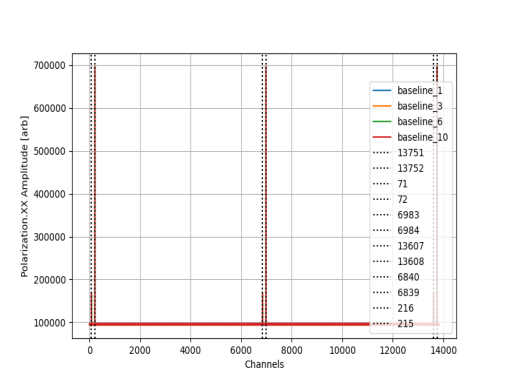

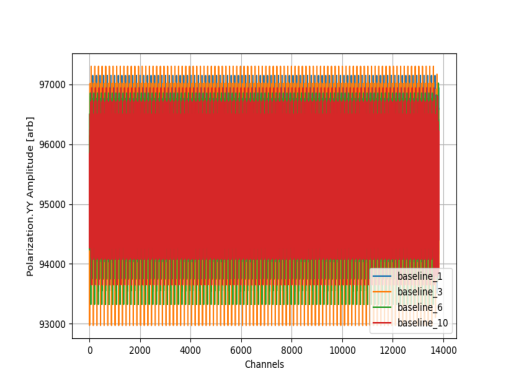

In [44]:
buf = {
    "xx": plotting.plot_time_averaged_amplitude_vs_channel(pcap_output_1, station_baseline_mapping.auto_indices,Polarization.XX, scan_id=SCAN_1_ID),
    "yy": plotting.plot_time_averaged_amplitude_vs_channel(pcap_output_1, station_baseline_mapping.auto_indices,Polarization.YY, scan_id =SCAN_1_ID)
}
for each in buf.values():
    img = Image.open(BytesIO(each))
    plt.imshow(img, aspect="auto")
    plt.axis("off")
    plt.show()

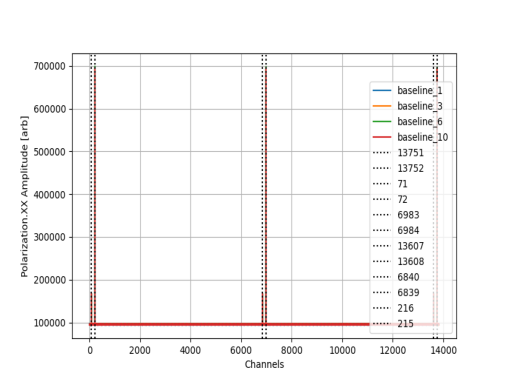

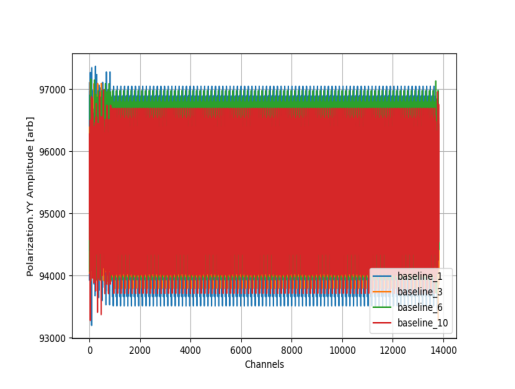

In [45]:
buf = {
    "xx": plotting.plot_time_averaged_amplitude_vs_channel(pcap_output_2, station_baseline_mapping.auto_indices,Polarization.XX, scan_id=SCAN_2_ID),
    "yy": plotting.plot_time_averaged_amplitude_vs_channel(pcap_output_2, station_baseline_mapping.auto_indices,Polarization.YY, scan_id =SCAN_2_ID)
}
for each in buf.values():
    img = Image.open(BytesIO(each))
    plt.imshow(img, aspect="auto")
    plt.axis("off")
    plt.show()

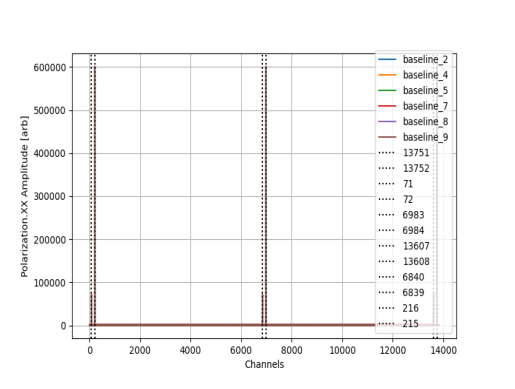

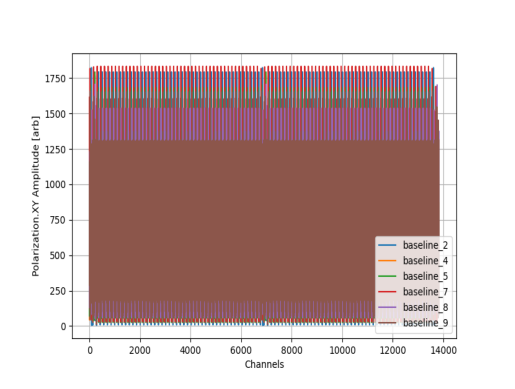

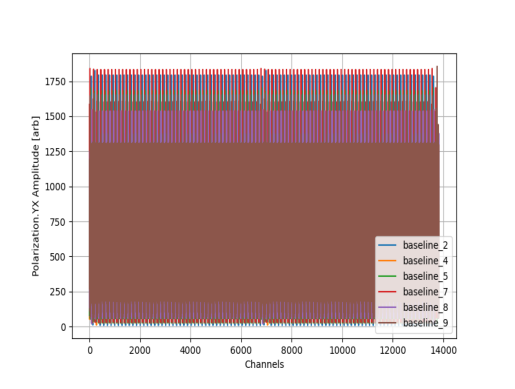

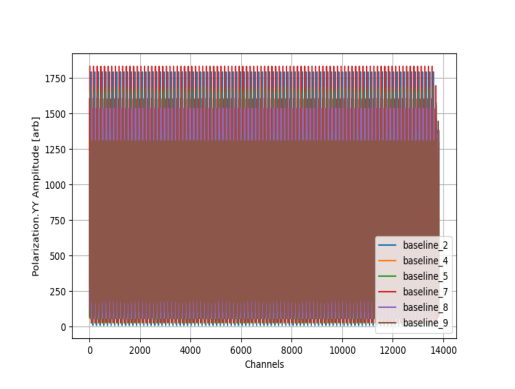

In [46]:
buf = {
    "xx": plotting.plot_time_averaged_amplitude_vs_channel(pcap_output_1, station_baseline_mapping.auto_indices, Polarization.XX, scan_id=SCAN_1_ID),
    "xy": plotting.plot_time_averaged_amplitude_vs_channel(pcap_output_1, station_baseline_mapping.auto_indices, Polarization.XY, scan_id =SCAN_1_ID),
    "yx": plotting.plot_time_averaged_amplitude_vs_channel(pcap_output_1, station_baseline_mapping.auto_indices, Polarization.YX, scan_id =SCAN_1_ID),
    "yy": plotting.plot_time_averaged_amplitude_vs_channel(pcap_output_1, station_baseline_mapping.auto_indices, Polarization.YY, scan_id =SCAN_1_ID)
}
for each in buf.values():
    img = Image.open(BytesIO(each))
    plt.imshow(img, aspect="auto")
    plt.axis("off")
    plt.show()

### Phase over channel

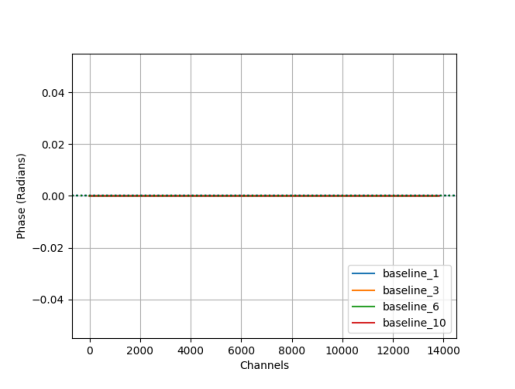

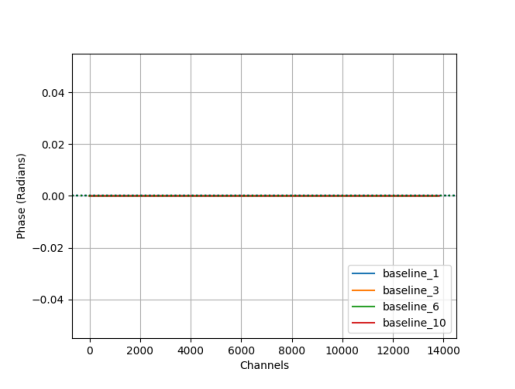

In [47]:
buf = {
    "xx": plotting.plot_time_averaged_phase_vs_channel(pcap_output_1, station_baseline_mapping.cross_sample(), plotting.Polarization.XX, scan_id=SCAN_1_ID),
    "yy": plotting.plot_time_averaged_phase_vs_channel(pcap_output_1, station_baseline_mapping.cross_sample(), plotting.Polarization.YY, scan_id=SCAN_1_ID),
}
for each in buf.values():
    img = Image.open(BytesIO(each))
    plt.imshow(img, aspect="auto")
    plt.axis("off")
    plt.show()

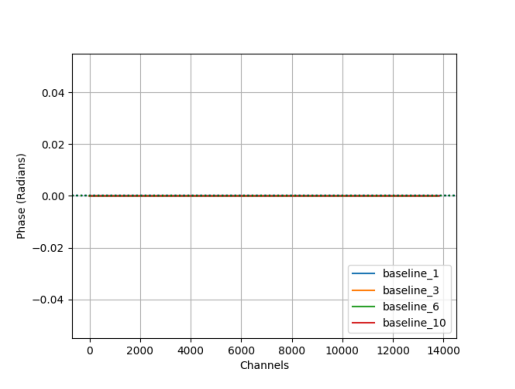

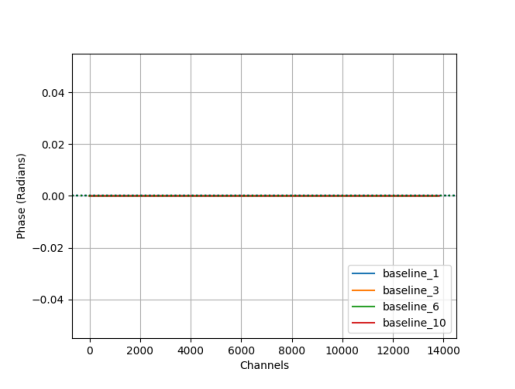

In [48]:
buf = {
    "xy": plotting.plot_time_averaged_phase_vs_channel(pcap_output_2, station_baseline_mapping.cross_sample(), plotting.Polarization.XY, scan_id=SCAN_1_ID),
    "yx": plotting.plot_time_averaged_phase_vs_channel(pcap_output_2, station_baseline_mapping.cross_sample(), plotting.Polarization.YX, scan_id=SCAN_1_ID),
}
for each in buf.values():
    img = Image.open(BytesIO(each))
    plt.imshow(img, aspect="auto")
    plt.axis("off")
    plt.show()

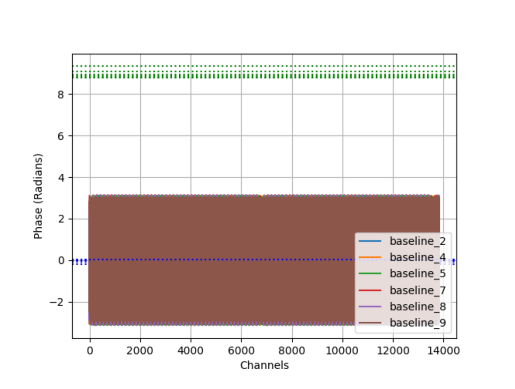

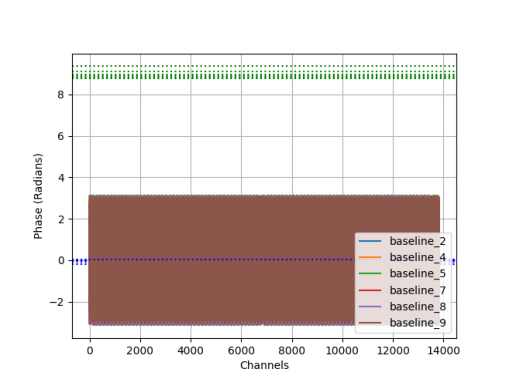

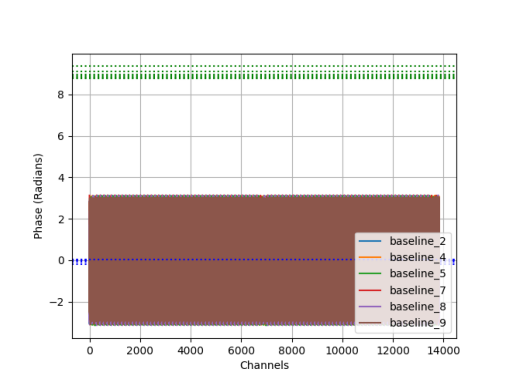

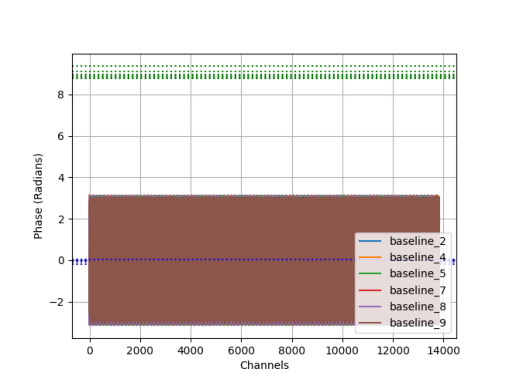

In [49]:
buf = {
    "xx": plotting.plot_time_averaged_phase_vs_channel(pcap_output_1, station_baseline_mapping.cross_sample(), plotting.Polarization.XX, scan_id=SCAN_1_ID),
    "xy": plotting.plot_time_averaged_phase_vs_channel(pcap_output_1, station_baseline_mapping.cross_sample(), plotting.Polarization.XY, scan_id=SCAN_1_ID),
    "yx": plotting.plot_time_averaged_phase_vs_channel(pcap_output_1, station_baseline_mapping.cross_sample(), plotting.Polarization.YX, scan_id=SCAN_1_ID),
    "yy": plotting.plot_time_averaged_phase_vs_channel(pcap_output_1, station_baseline_mapping.cross_sample(), plotting.Polarization.YY, scan_id=SCAN_1_ID),
}
for each in buf.values():
    img = Image.open(BytesIO(each))
    plt.imshow(img, aspect="auto")
    plt.axis("off")
    plt.show()